#  Customers Segmentation

### we need to create a customer segmentation model to recommend the best merchants for each user as targetted offers

In [119]:
# Importing libraries
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jb
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

## Data Info

In [2]:
# Read Dataset
df = pd.read_csv('Cleaned_Data_Merchant_Name.csv')
df.sample(20)

,Trx_Rank,Points,Trx_Vlu,Trx_Age,Customer_Age,Category In English,User_Id,Mer_Name
27652,1,180,18.0,315,41,Grocery,29562,Rajasthan Handicrafts
13463,3,1420,142.0,27,27,Grocery,5243,Rajasthan Handicrafts
3959,1,1019,101.9,251,251,Grocery,19034,Saraswati Fabrics
549,1,2600,260.0,141,141,Grocery,2895,Saraswati Fabrics
28383,3,8880,888.0,202,202,Grocery,30941,Rajasthan Handicrafts
7222,1,2425,242.5,52,52,F&B,1619,Jai Hind General Stores
20263,1,1980,198.0,50,50,Grocery,16844,Rajasthan Handicrafts
39217,1,2400,240.0,193,20,Fashion,27906,Faridabad Footwear Fair
19903,2,1020,102.0,96,96,Grocery,16276,Rajasthan Handicrafts
28809,1,3520,352.0,286,286,Grocery,31738,Rajasthan Handicrafts


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43672 entries, 0 to 43671
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Trx_Rank             43672 non-null  int64  
 1   Points               43672 non-null  int64  
 2   Trx_Vlu              43672 non-null  float64
 3   Trx_Age              43672 non-null  int64  
 4   Customer_Age         43672 non-null  int64  
 5   Category In English  43672 non-null  object 
 6   User_Id              43672 non-null  int64  
 7   Mer_Name             43672 non-null  object 
dtypes: float64(1), int64(5), object(2)
memory usage: 2.7+ MB


In [4]:
# Check Duplication
df.duplicated().sum()

0

In [5]:
# Drop nan Values
df.dropna(inplace=True,axis=0)

In [6]:
# Check Count of unique values in each feature
for col in df.columns:
    print ((col.ljust(20)), '=>' , (df[col].nunique()))

Trx_Rank             => 17
Points               => 5911
Trx_Vlu              => 5911
Trx_Age              => 573
Customer_Age         => 527
Category In English  => 7
User_Id              => 33457
Mer_Name             => 56


In [7]:
## check the unique values of each feature 
for col in df.columns:
    print (col)
    print(df[col].unique())
    print(50*'*')

Trx_Rank
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
**************************************************
Points
[20140 11200  8500 ...  3832  4731  1954]
**************************************************
Trx_Vlu
[2014.  1120.   850.  ...  383.2  473.1  195.4]
**************************************************
Trx_Age
[362 371 368 558 413  34  33 233  14  27  47  39  37   5  55 102 419 306
 503  13 328 321 355 356  29  41 334 262 454 304 300 261 258 225 259 271
 311 111 266 292 237 287 270 243 254 168 269 305 276 234 201  91 302  79
 279  73 251 296 307 260 153 256 224 250 136  51 244  77 156 285 188 245
 264 309 164 297  57 265 236 126  76  60 315 232 299  44 281 272 144 101
 145 303 127 138 211 155  20 176  68 308 163 193 161 235 125  75 223 121
 274 298 152  52 253 124 267  74  78 216 255  46 179 213 197 169 249 194
 252 240 104 200 166 154 192  58 143 230  31 257  96 282   7 275 135  40
 148 118 227  35 165 113 103 190 268 212 187  19 214 110  94 219 290 289
 301 294 210 28

## EDA and Cleaning

In [8]:
# Check if any row has customer age more than trx age
df.loc[(df['Customer_Age'] > df['Trx_Age'])]

,Trx_Rank,Points,Trx_Vlu,Trx_Age,Customer_Age,Category In English,User_Id,Mer_Name


In [9]:
# Check if there is wrong trx value or points 
df.loc[df['Points'] != df['Trx_Vlu']*10]

,Trx_Rank,Points,Trx_Vlu,Trx_Age,Customer_Age,Category In English,User_Id,Mer_Name


In [10]:
# create a dictionary to map values to numbers
Categories= {'Fashion': 1, 'F&B': 2, 'Grocery': 3, 'Transportaion': 4,'Electronics' : 5, 'Health & Beauty' : 6,
             'Other' : 7 }

# use the map function to apply the mapping to the column
df['Categories'] = df['Category In English'].map(Categories)

In [11]:
df['Categories'].unique()

array([1, 2, 7, 3, 4, 5, 6], dtype=int64)

In [12]:
mode_df = df.groupby(['User_Id', 'Categories']).size().reset_index(name='counts').sort_values(['User_Id', 'counts'], ascending=[True, False]).drop_duplicates(subset=['User_Id'])
mapping = dict(zip(mode_df['User_Id'], mode_df['Categories']))
df['Most_Frequent_Category'] = df['User_Id'].map(mapping)
df

,Trx_Rank,Points,Trx_Vlu,Trx_Age,Customer_Age,Category In English,User_Id,Mer_Name,Categories,Most_Frequent_Category
0,1,20140,2014.0,362,362,Fashion,21053,Shankar Traders,1,1
1,1,11200,1120.0,371,368,Fashion,26472,Shankar Traders,1,1
2,2,8500,850.0,368,368,Fashion,26472,Shankar Traders,1,1
3,1,1980,198.0,558,34,Fashion,27075,Shankar Traders,1,1
4,1,2400,240.0,413,413,Fashion,27417,Shankar Traders,1,1
...,...,...,...,...,...,...,...,...,...,...
43667,1,3050,305.0,27,27,F&B,26865,Cuttack Curtain Corner,2,2
43668,1,3120,312.0,31,31,F&B,27128,Cuttack Curtain Corner,2,2
43669,1,1200,120.0,25,25,F&B,28814,Cuttack Curtain Corner,2,2
43670,1,20,2.0,2,2,Other,29107,Rourkela Rice Retail,7,7


In [13]:
df['Most_Frequent_Category'].unique()

array([1, 2, 3, 7, 6, 4, 5], dtype=int64)

In [14]:
# Make data frame of RFM for all Customers
rfm=df.groupby('User_Id').agg({'Customer_Age':lambda age:age.mean(),
                               'Trx_Rank':lambda freq:freq.max(),
                               'Trx_Vlu':lambda money:money.sum(),
                              'Most_Frequent_Category':lambda category:category.mode()})
rfm

,Customer_Age,Trx_Rank,Trx_Vlu,Most_Frequent_Category
User_Id,,,,
0,281.0,1,442.7,2
1,34.0,1,249.0,1
2,236.0,1,300.0,2
3,320.0,1,162.0,1
4,407.0,1,70.0,3
...,...,...,...,...
33514,101.0,3,594.0,3
33515,244.0,1,48.0,2
33516,256.0,1,132.0,3


In [15]:
rfm['Most_Frequent_Category'].unique()

array([2, 1, 3, 6, 5, 4, 7], dtype=int64)

In [16]:
# Change Columns Name
rfm.columns=['Recency','Frequency','Monetary','Most_Frequent_Category']
rfm

,Recency,Frequency,Monetary,Most_Frequent_Category
User_Id,,,,
0,281.0,1,442.7,2
1,34.0,1,249.0,1
2,236.0,1,300.0,2
3,320.0,1,162.0,1
4,407.0,1,70.0,3
...,...,...,...,...
33514,101.0,3,594.0,3
33515,244.0,1,48.0,2
33516,256.0,1,132.0,3


In [17]:
# Check if any Monetary < 0
rfm[rfm.Monetary<0]

,Recency,Frequency,Monetary,Most_Frequent_Category
User_Id,,,,


In [18]:
# Divid every item of RFM to score to 5 quantiles so we can handle them easier
rfm['Recency_Score']=pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])
rfm['Frequency_Score']=pd.qcut(rfm['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
rfm['Monetary_Score']=pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])
rfm.sample(20)

,Recency,Frequency,Monetary,Most_Frequent_Category,Recency_Score,Frequency_Score,Monetary_Score
User_Id,,,,,,,
29905,195.0,1,234.0,3,3,4,3
9558,218.0,1,194.0,1,2,2,3
32152,107.0,1,96.0,3,3,5,1
17692,211.0,1,160.0,3,3,3,2
28822,20.0,2,500.0,6,5,5,5
10127,2.0,1,230.7,3,5,2,3
5117,295.0,1,90.0,6,1,1,1
24272,239.0,1,216.7,3,2,4,3
25506,53.0,1,222.0,3,4,4,3


In [19]:
# Get one RFM score of RFM Scores so we can handle with one number at the end reflects the all scores
rfm['RFM_Score']=(rfm['Recency_Score'].astype(str)+
                  rfm['Monetary_Score'].astype(str)+rfm['Frequency_Score'].astype(str))
rfm.reset_index(inplace=True)
rfm.sample(20)

,User_Id,Recency,Frequency,Monetary,Most_Frequent_Category,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
20713,20734,370.0,1,132.0,2,1,3,1,113
28626,28684,58.0,2,341.3,3,4,5,4,445
19780,19796,159.0,1,89.4,3,3,3,1,313
23804,23830,34.0,1,9.3,3,5,4,1,514
6724,6731,269.0,1,110.0,3,2,1,1,211
2063,2066,110.0,2,350.0,3,3,5,4,345
22559,22584,297.0,1,393.8,3,1,3,4,143
3774,3778,312.0,1,100.0,2,1,1,1,111
10770,10778,256.0,1,319.0,1,2,2,4,242
18270,18283,1.0,1,192.0,2,5,3,3,533


In [20]:
# extract specific columns and save them as a new dataframe
RFM_Final = rfm[['User_Id','Recency_Score', 'Frequency_Score','Monetary_Score','RFM_Score',
                 'Most_Frequent_Category']]
RFM_Final

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category
0,0,1,1,5,151,2
1,1,5,1,3,531,1
2,2,2,1,4,241,2
3,3,1,1,2,121,1
4,4,1,1,1,111,3
...,...,...,...,...,...,...
33452,33514,3,5,5,355,3
33453,33515,2,5,1,215,2
33454,33516,2,5,1,215,3
33455,33517,5,5,3,535,3


In [21]:
# Check Datatype of all columns 
RFM_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33457 entries, 0 to 33456
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   User_Id                 33457 non-null  int64   
 1   Recency_Score           33457 non-null  category
 2   Frequency_Score         33457 non-null  category
 3   Monetary_Score          33457 non-null  category
 4   RFM_Score               33457 non-null  object  
 5   Most_Frequent_Category  33457 non-null  int64   
dtypes: category(3), int64(2), object(1)
memory usage: 882.9+ KB


In [22]:
# convert columns to numeric data type
RFM_Final = RFM_Final.apply(pd.to_numeric)

In [23]:
RFM_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33457 entries, 0 to 33456
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   User_Id                 33457 non-null  int64
 1   Recency_Score           33457 non-null  int64
 2   Frequency_Score         33457 non-null  int64
 3   Monetary_Score          33457 non-null  int64
 4   RFM_Score               33457 non-null  int64
 5   Most_Frequent_Category  33457 non-null  int64
dtypes: int64(6)
memory usage: 1.5 MB


In [24]:
# Scale Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(RFM_Final)
df_scaled = pd.DataFrame(rfm_scaled, columns=RFM_Final.columns)
df_scaled.sample(10)

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category
16229,-0.052791,0.684367,0.000000,1.414675,0.801045,0.274959
12319,-0.457056,0.684367,-0.707086,0.004342,0.657785,0.274959
25019,0.857426,1.387286,0.707086,0.004342,1.353620,-0.890100
1526,-1.573023,-0.018551,-1.414171,0.004342,-0.031228,-2.055160
778,-1.650528,1.387286,-1.414171,-0.700825,1.264935,0.274959
18659,0.198738,0.684367,1.414171,0.709508,0.746470,0.274959
28994,1.271405,-1.424389,0.707086,-1.405991,-1.511583,0.274959
26225,0.982880,1.387286,0.707086,1.414675,1.490058,0.274959
11206,-0.572074,0.684367,1.414171,1.414675,0.814689,-0.890100
4415,-1.274164,1.387286,-1.414171,0.004342,1.333154,-0.890100


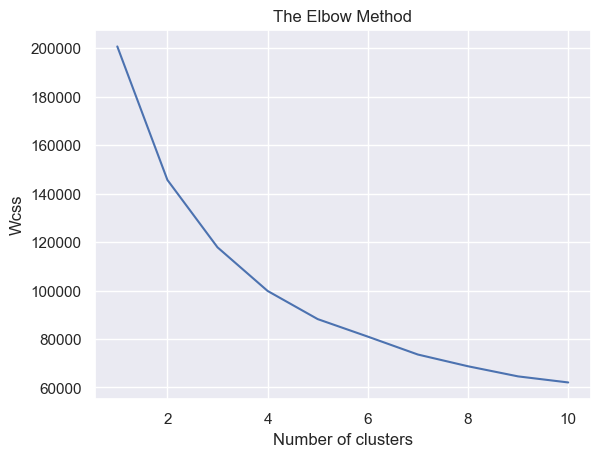

In [25]:
# Elbow method
wcss = []
for k in range(1 , 11):
    Model = KMeans(n_clusters = k, random_state=42)
    Model.fit(df_scaled)
    wcss.append(Model.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Wcss')
plt.show()

In [26]:
Model = KMeans(n_clusters=5)
Model.fit(df_scaled)
df_scaled['Cluster'] = Model.predict(df_scaled)
df_scaled.head()

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category,Cluster
0,-1.730926,-1.424389,-1.414171,1.414675,-1.259172,-0.890100,1
1,-1.730823,1.387286,-1.414171,0.004342,1.333154,-2.055160,3
2,-1.730719,-0.721470,-1.414171,0.709508,-0.645200,-0.890100,1
3,-1.730616,-1.424389,-1.414171,-0.700825,-1.463829,-2.055160,1
4,-1.730513,-1.424389,-1.414171,-1.405991,-1.532048,0.274959,1


In [27]:
centers = Model.cluster_centers_

In [28]:
print(centers)

[[ 0.49092604  1.06216236  0.82850185  0.41591925  1.07907109  0.03823948]
 [-0.94744027 -0.83234288 -1.05911426 -0.64187858 -0.88011326  0.04783196]
 [ 0.73349093 -0.87456637  0.52558157 -0.96743072 -0.93729713  0.05998802]
 [-0.95336299  0.81521335 -1.05992258  0.17762802  0.79813208 -0.05500084]
 [ 0.71211668 -0.60744085  0.6730147   0.80872549 -0.50479766 -0.09948413]]


<AxesSubplot:xlabel='User_Id', ylabel='RFM_Score'>

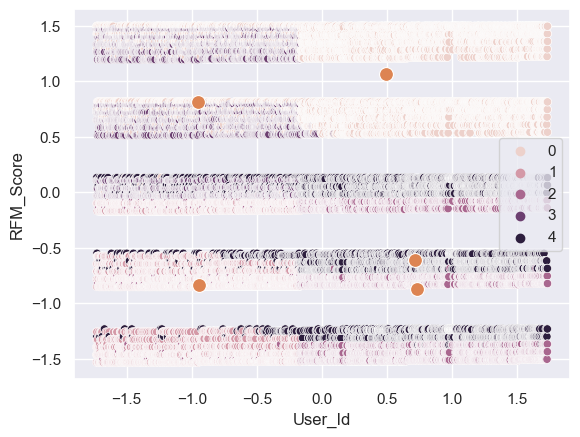

In [29]:
sns.scatterplot(data = df_scaled , x = 'User_Id' , y = 'RFM_Score' , hue = 'Cluster')
sns.scatterplot(x = centers[ : , 0 ] , y = centers[ : , 1 ] , s = 100  )

In [30]:
# Calculate the silhouette score
score = silhouette_score(df_scaled, Model.labels_)
print(f"The silhouette score is {score:.2f}")

The silhouette score is 0.39


## Let's try combination of two variables together only

In [44]:
rfm1 = RFM_Final[['User_Id' , 'RFM_Score']]

In [45]:
sclr = StandardScaler()
rfm1[rfm1.columns] = sclr.fit_transform(rfm1[rfm1.columns])
rfm1.head()

,User_Id,RFM_Score
0,-1.730926,-1.259172
1,-1.730823,1.333154
2,-1.730719,-0.645200
3,-1.730616,-1.463829
4,-1.730513,-1.532048


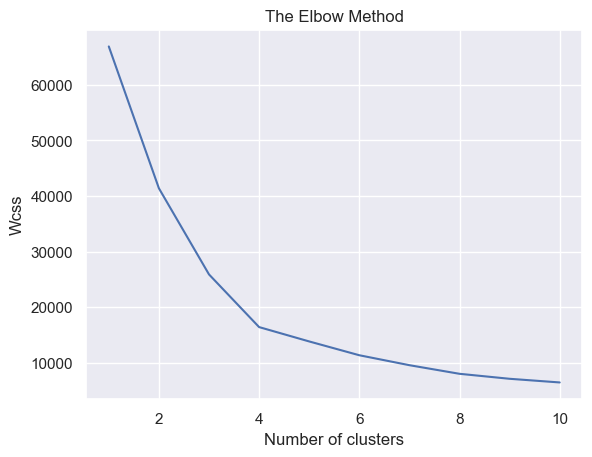

In [46]:
# Elbow method
wcss = []
for k in range(1 , 11):
    Model = KMeans(n_clusters = k, random_state=42)
    Model.fit(rfm1)
    wcss.append(Model.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Wcss')
plt.show()

In [95]:
Model = KMeans(n_clusters=6)
Model.fit(rfm1)
rfm1 ['Cluster'] = Model.predict(rfm1)
rfm1.head()

,User_Id,RFM_Score,Cluster
0,-1.730926,-1.259172,3
1,-1.730823,1.333154,2
2,-1.730719,-0.645200,3
3,-1.730616,-1.463829,3
4,-1.730513,-1.532048,3


In [97]:
centers = Model.cluster_centers_

<AxesSubplot:xlabel='User_Id', ylabel='RFM_Score'>

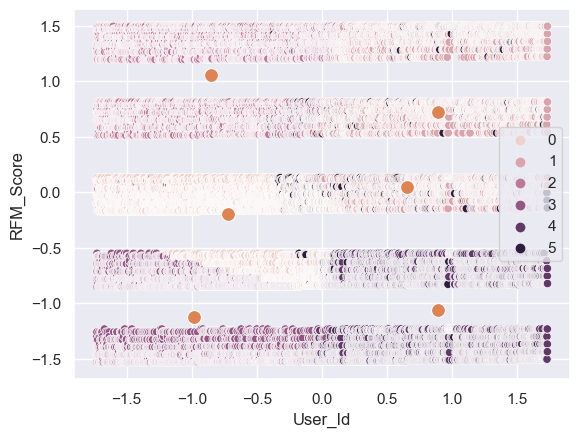

In [98]:
sns.scatterplot(data = rfm1 , x = 'User_Id' , y = 'RFM_Score' , hue = 'Cluster')
sns.scatterplot(x = centers[ : , 0 ] , y = centers[ : , 1 ] , s = 100  )

In [96]:
# Calculate the silhouette score
score = silhouette_score(rfm1, Model.labels_)
print(f"The silhouette score is {score:.2f}")

The silhouette score is 0.56


## Let's try another combination

In [59]:
rfm2 = RFM_Final[['User_Id' , 'RFM_Score' , 'Most_Frequent_Category']]

In [60]:
sclr = StandardScaler()
rfm2[rfm2.columns] = sclr.fit_transform(rfm2[rfm2.columns])
rfm2.head()

,User_Id,RFM_Score,Most_Frequent_Category
0,-1.730926,-1.259172,-0.890100
1,-1.730823,1.333154,-2.055160
2,-1.730719,-0.645200,-0.890100
3,-1.730616,-1.463829,-2.055160
4,-1.730513,-1.532048,0.274959


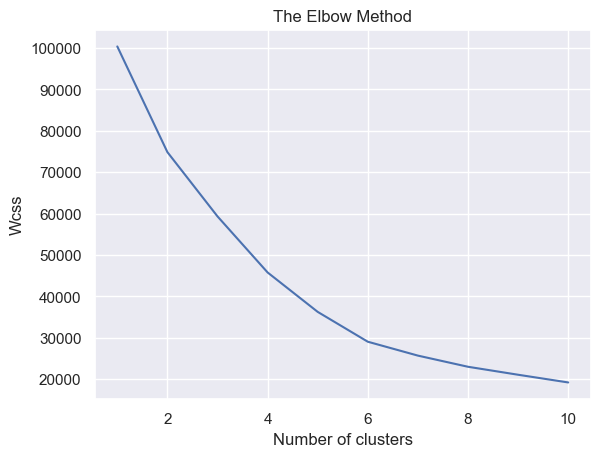

In [61]:
# Elbow method
wcss = []
for k in range(1 , 11):
    Model = KMeans(n_clusters = k, random_state=42)
    Model.fit(rfm2)
    wcss.append(Model.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Wcss')
plt.show()

In [89]:
Model = KMeans(n_clusters=6)
Model.fit(rfm2)
rfm2 ['Cluster'] = Model.predict(rfm2)
rfm2.head()

,User_Id,RFM_Score,Most_Frequent_Category,Cluster
0,-1.730926,-1.259172,-0.890100,1
1,-1.730823,1.333154,-2.055160,3
2,-1.730719,-0.645200,-0.890100,1
3,-1.730616,-1.463829,-2.055160,1
4,-1.730513,-1.532048,0.274959,1


In [90]:
# Calculate the silhouette score
score = silhouette_score(rfm2, Model.labels_)
print(f"The silhouette score is {score:.2f}")

The silhouette score is 0.53


# Let's try hierarchical clustering 

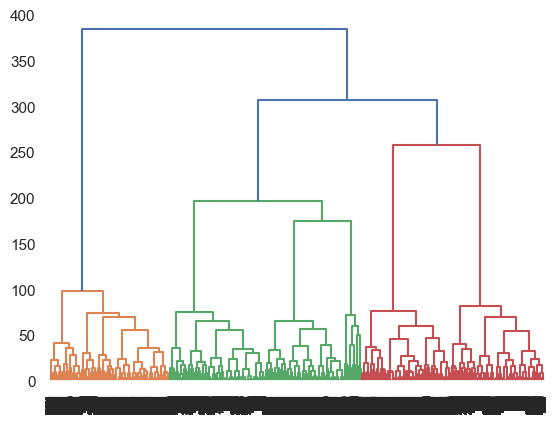

In [76]:
dendrogram = sch.dendrogram(sch.linkage(df_scaled,method='ward'))
hier_model = AgglomerativeClustering(n_clusters=5).fit(df_scaled)

In [77]:
score = silhouette_score(df_scaled, hier_model.labels_)
print(score)

0.38354835753732985


# let's try by DBSCAN 

In [86]:
# Perform DBSCAN clustering
clustering = DBSCAN(eps=1, min_samples=2).fit(df_scaled)

# Calculate silhouette score
score = silhouette_score(df_scaled, clustering.labels_)

# Print silhouette score
print(score)

0.09643209821579445


## The Best score was for K-Means for second combination ( 'User_Id' , 'RFM_Score')

In [99]:
# Rename column user_id for merging
rfm1 = rfm1.rename(columns={'User_Id': 'User_Id_Scaled'})

In [106]:
# Scale the User_Id column in RFM_Final DataFrame
RFM_Final['User_Id_Scaled'] = scaler.fit_transform(RFM_Final[['User_Id']])

# Merge the two dataframes on the User_Id_Scaled column
RFM_Final = RFM_Final.merge(rfm1[['User_Id_Scaled', 'Cluster']], on='User_Id_Scaled')

# Drop the User_Id_Scaled column from the merged dataframe
RFM_Final = RFM_Final.drop('User_Id_Scaled', axis=1)

# Print the updated dataframe
RFM_Final

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category,Cluster_x,Cluster_x,Cluster_y
0,0,1,1,5,151,2,3,3,3
1,1,5,1,3,531,1,2,2,2
2,2,2,1,4,241,2,3,3,3
3,3,1,1,2,121,1,3,3,3
4,4,1,1,1,111,3,3,3,3
...,...,...,...,...,...,...,...,...,...
33452,33514,3,5,5,355,3,1,1,1
33453,33515,2,5,1,215,2,4,4,4
33454,33516,2,5,1,215,3,4,4,4
33455,33517,5,5,3,535,3,1,1,1


In [109]:
# Rename column cluster
RFM_Final = RFM_Final.rename(columns={'Cluster_y': 'Cluster'})

RFM_Final

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category,Cluster
0,0,1,1,5,151,2,3
1,1,5,1,3,531,1,2
2,2,2,1,4,241,2,3
3,3,1,1,2,121,1,3
4,4,1,1,1,111,3,3
...,...,...,...,...,...,...,...
33452,33514,3,5,5,355,3,1
33453,33515,2,5,1,215,2,4
33454,33516,2,5,1,215,3,4
33455,33517,5,5,3,535,3,1


In [112]:
# create a dictionary to map numbers to values
Categories1= {1 :'Fashion', 2 :'F&B', 3 :'Grocery', 4 : 'Transportaion', 5 : 'Electronics' , 6 : 'Health & Beauty',
             7 : 'Other'}

# use the map function to apply the mapping to the column
RFM_Final['Category_In_English'] = RFM_Final['Most_Frequent_Category'].map(Categories1)
RFM_Final

,User_Id,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Most_Frequent_Category,Cluster,Category_In_English
0,0,1,1,5,151,2,3,F&B
1,1,5,1,3,531,1,2,Fashion
2,2,2,1,4,241,2,3,F&B
3,3,1,1,2,121,1,3,Fashion
4,4,1,1,1,111,3,3,Grocery
...,...,...,...,...,...,...,...,...
33452,33514,3,5,5,355,3,1,Grocery
33453,33515,2,5,1,215,2,4,F&B
33454,33516,2,5,1,215,3,4,Grocery
33455,33517,5,5,3,535,3,1,Grocery


In [114]:
# Group the dataframe by the 'clusters' column
grouped = RFM_Final.groupby('Cluster')

# Get the top 3 categories for each cluster
top_categories = grouped['Category_In_English'].value_counts().groupby(level=0).nlargest(3)

# Print the top categories for each cluster
print(top_categories)

Cluster  Cluster  Category_In_English
0        0        Grocery                3476
                  F&B                     536
                  Fashion                 245
1        1        Grocery                6829
                  F&B                    1059
                  Transportaion            37
2        2        Grocery                5329
                  F&B                     980
                  Fashion                 734
3        3        Grocery                3435
                  F&B                    1070
                  Fashion                 356
4        4        Grocery                4604
                  F&B                    1698
                  Fashion                  63
5        5        Fashion                1334
                  Health & Beauty         521
                  F&B                     432
Name: Category_In_English, dtype: int64


In [115]:
# Group the dataframe by the 'Category' column
grouped = df.groupby('Category In English')

# Get the top 3 'Mer_Name' for each 'Category'
top_mer_names = grouped['Mer_Name'].value_counts().groupby(level=0).nlargest(3)

# Print the top 'Mer_Name' for each 'Category'
print(top_mer_names)

Category In English  Category In English  Mer_Name                 
Electronics          Electronics          Gwalior Garden Gear            133
                                          Thane Tea Traders               43
                                          Nagpur Novelty Nook             25
F&B                  F&B                  Jai Hind General Stores       3387
                                          Amritsar Auto Accessories     1302
                                          Gurgaon Gift Gallery          1012
Fashion              Fashion              Agra Appliance Arena          2963
                                          Faridabad Footwear Fair        311
                                          Delhi Electronics               36
Grocery              Grocery              Rajasthan Handicrafts        19361
                                          Saraswati Fabrics             6896
                                          Madurai Music Mania           4269
Health &

In [120]:
jb.dump(RFM_Final,"RFM_Final_DF.pkl")

['RFM_Final_DF.pkl']

In [127]:
%%writefile streamlit_app_Customers_Segmentation.py

import joblib
import streamlit as st
import category_encoders
import pandas as pd
import sklearn

RFM_Final_DF_Load= joblib.load("RFM_Final_DF.pkl")

def Category(User_Id):
    # Get the cluster number for the user_id
    cluster = RFM_Final_DF_Load.loc[RFM_Final_DF_Load['User_Id'] == User_Id, 'Cluster'].values[0]
    # Show the appropriate message based on the cluster number
    if cluster == 0:
        return ' Rajasthan Handicrafts, Saraswati Fabrics, Madurai Music Mania Or Jai Hind General Stores, Amritsar Auto Accessories, Gurgaon Gift Gallery'
    elif cluster == 1:
        return ' Rajasthan Handicrafts, Saraswati Fabrics, Madurai Music Mania Or Jai Hind General Stores, Amritsar Auto Accessories, Gurgaon Gift Gallery'
    elif cluster == 2:
        return ' Rajasthan Handicrafts, Saraswati Fabrics, Madurai Music Mania Or Jai Hind General Stores, Amritsar Auto Accessories Or Agra Appliance Arena, Faridabad Footwear Fair'
    elif cluster == 3:
        return ' Rajasthan Handicrafts, Saraswati Fabrics, Madurai Music Mania Or Jai Hind General Stores, Amritsar Auto Accessories, Gurgaon Gift Gallery'
    elif cluster == 4:
        return ' Rajasthan Handicrafts, Saraswati Fabrics, Madurai Music Mania Or Jai Hind General Stores, Amritsar Auto Accessories, Gurgaon Gift Gallery'
    elif cluster == 5:
        return ' Agra Appliance Arena, Faridabad Footwear Fair, Delhi Electronics Or Indore Instrument Inn Or Jai Hind General Stores '

def main():    
    ## Setting up the page title
    st.set_page_config(page_title= 'Customers Segmentation')
    
     # Add a title in the middle of the page using Markdown and CSS
    st.markdown("<h1 style='text-align: center;text-decoration: underline;color:GoldenRod'>Customers Segmentation</h1>", unsafe_allow_html=True)
    
    User_Id=st.number_input('Insert User ID, Please',min_value=0, max_value=33457, value=10000,step=50)
    
    if st.button('Confirm'):
        Result = Category(User_Id)
        st.text(f"We recommend to you {Result} ")
        
main()


Overwriting streamlit_app_Customers_Segmentation.py


In [128]:
!streamlit run streamlit_app_Customers_Segmentation.py

^C
